Dry


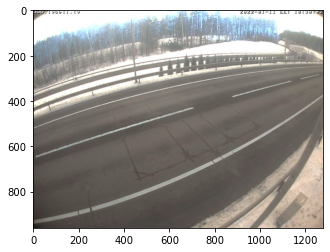

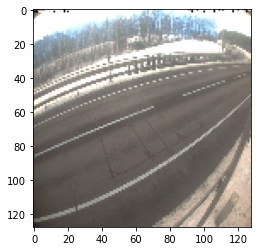

Snow


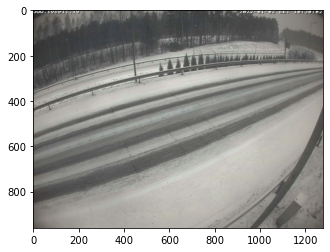

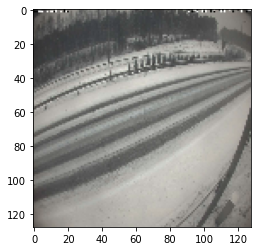

Wet


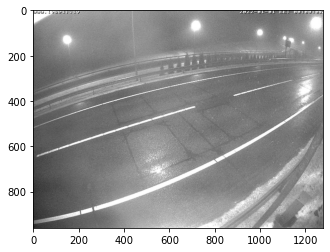

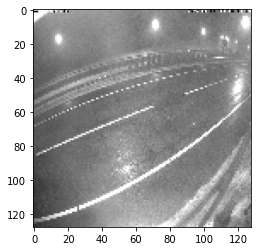

Image size (Width, Height, Dimensions) = (960, 1280, 3):
Resized Images to size 128x128


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

IMG_SIZE = 128 

DATADIR = 'dataset/'
CATEGORIES = ["Dry", "Snow", "Wet"]

for category in CATEGORIES:
    print(category)
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.show()
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        plt.imshow(new_array)
        plt.show()
        break

print("Image size (Width, Height, Dimensions) = {}:".format(img_array.shape))      
print("Resized Images to size {}x{}".format(IMG_SIZE, IMG_SIZE)) 

Found 3 images belonging to 3 classes.


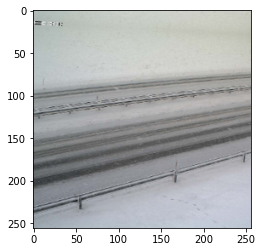

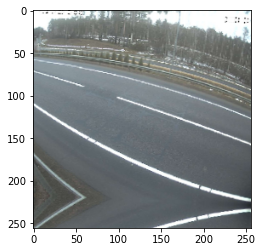

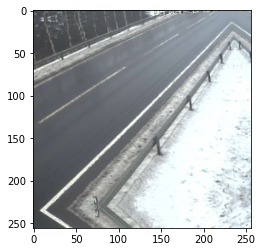

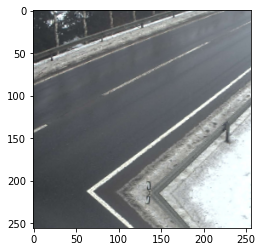

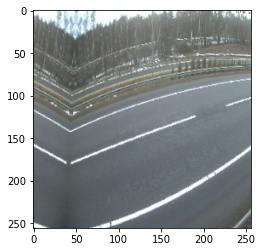

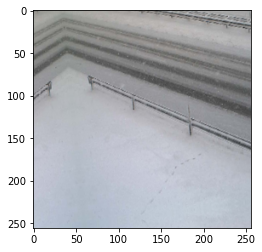

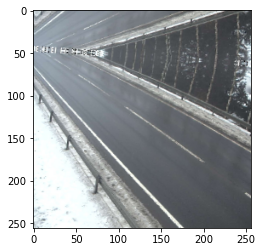

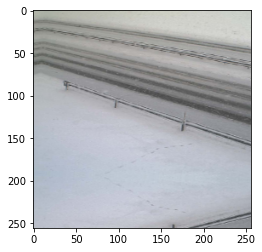

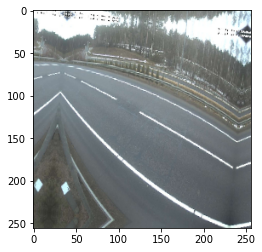

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

DATASET_DIR = 'preprocessing_result_dataset/'
IMAGE_SIZE = 256

datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.3,
    rotation_range=7,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2,
    fill_mode="reflect"
)

dir_It = datagen.flow_from_directory(
    DATASET_DIR,
    batch_size=1,
    save_to_dir="preprocessing_result/",
    save_prefix="",
    save_format='png',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
)

for _ in range(9):
    img, label = dir_It.next()
    plt.imshow(img[0])
    plt.show()

Found 3120 images belonging to 3 classes.
Found 780 images belonging to 3 classes.
Image input (128, 128, 3)
Classes: ['dry', 'snow', 'wet']
Model: "road-condition-classifiaction-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)

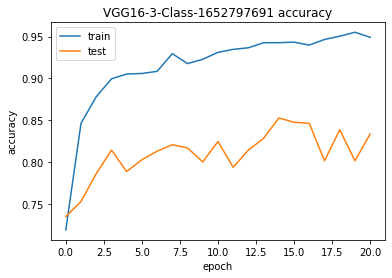

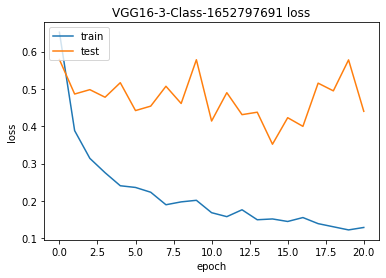

In [69]:
# *************** IMPORTS *************** #
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
import os
import time
import winsound

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers, applications, callbacks
from tensorflow.keras.callbacks import TensorBoard


CLASS_COUNT = 3


MODEL_NAME = "VGG16-{}-Class-{}".format(CLASS_COUNT, int(time.time()))
IMAGE_SIZE = 128
BATCH_SIZE = 32
H5_MODELS_DIR = 'models_h5/'
TFJS_MODELS_DIR = 'models_nodejs/'
DATASET_DIR = 'datasets/dataset_{}_class/dataset/'.format(CLASS_COUNT)
Tensorboard = TensorBoard(log_dir='logs/{}'.format(MODEL_NAME))

def savemodel(model, model_name):
    
    model.save(os.path.join(H5_MODELS_DIR, '{}.h5'.format(model_name)))
    tfjs.converters.save_keras_model(model, TFJS_MODELS_DIR)

    print("Model saved succesfully.")

def plot_history(history, name):
    # Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


if __name__ == "__main__":    
    
    img_data_gen = ImageDataGenerator(
        rescale = 1. / 255,
        zoom_range=0.3,
        rotation_range=7,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="reflect",
        validation_split = 0.2
    )
    
    train_generator = img_data_gen.flow_from_directory(
        directory=DATASET_DIR,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=True,
        subset='training'
    )

    test_generator = img_data_gen.flow_from_directory(
        directory=DATASET_DIR,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False,
        subset='validation'
    )
    
    num_samples = train_generator.n
    num_classes = train_generator.num_classes
    input_shape = train_generator.image_shape

    classnames = [k for k, v in train_generator.class_indices.items()]

    print("Image input %s" % str(input_shape))
    print("Classes: %r" % classnames)
    
    input_0 = Input(shape=input_shape)

    model = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_0)

    feature_extractor = Model(inputs=input_0, outputs=model.output)
    
    feature_extractor.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            
    input_t = feature_extractor.get_layer(index=0).input
    
    trainable_layers = ["block5_conv3"]
    
    for idx, layer in enumerate(feature_extractor.layers):
        if layer.name in trainable_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    output_extractor = feature_extractor.get_layer(name="block5_pool").output

    output_extractor = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(output_extractor)
    flatten = Flatten(input_shape=(7,7,512))(output_extractor)    
    dense = Dense(256, activation='relu', input_dim=(7*7*512))(flatten)
    dense = Dropout(0.5)(dense)
    dense = Dense(num_classes, activation='softmax')(dense)

    model = Model(inputs=input_t, outputs=dense, name="road-condition-classifiaction-model")

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    model.summary()

    steps_per_epoch = train_generator.n // train_generator.batch_size
    val_steps = test_generator.n // test_generator.batch_size + 1
    
    stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=6)

    try:          
        history = model.fit(
            train_generator, 
            epochs=50, 
            verbose=1, 
            callbacks=[stopping, Tensorboard], 
            validation_data=test_generator
        )
    except KeyboardInterrupt:
        pass


    savemodel(model, MODEL_NAME)
    
    plot_history(history, MODEL_NAME)
    
    for index in range(30):
        winsound.Beep(500, 500)    
    

In [83]:
import tensorflow as tf

NAME = "VGG16-3-Class-1652797691"

model = tf.keras.models.load_model("models_h5\{}.h5".format(NAME))

In [84]:
import cv2
import numpy as np
from keras.preprocessing import image

CLASSES = ['dry', 'snow', 'wet']

IMG_SIZE = 128 
IMG_PATH = 'datasets/dataset_3_class/dataset_test/dry/Dry_1301.jpg'

img = image.load_img(IMG_PATH, target_size=(IMG_SIZE, IMG_SIZE))
img = np.asarray(img) / 255.
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)

predictions = model.predict(img)

print("")
print("Probabbility: ")
print("")

index = 0

for pValue in predictions:
    for value in pValue:
        print("(Arr_index: {}) - {}  - {} %".format(index, CLASSES[int(index)], str(value*100)))
        index = index + 1
        
print("")

classes = np.argmax(predictions, axis = 1)

print('Predicted classification - {} (Arr_index: {})'.format(CLASSES[int(classes[0])], classes[0]))


Probabbility: 

(Arr_index: 0) - dry  - 99.95101690292358 %
(Arr_index: 1) - snow  - 1.2278667860243786e-06 %
(Arr_index: 2) - wet  - 0.048987328773364425 %

Predicted classification - dry (Arr_index: 0)


In [5]:
# To check model training logs.

# Open anaconda promt
# cd C:\Users\Krisjanis\Desktop\BakalauraDarbs\road-surface-condition-assesment\model
# tensorboard --logdir=logs
# w*

1


In [41]:
import tensorflow as tf

NAME = "VGG16-3-Class-1652797691"

model = tf.keras.models.load_model("models_h5\{}.h5".format(NAME))

In [42]:
import os
import cv2
import numpy as np

from keras.preprocessing import image

IMG_SIZE = 128 

CLASS_COUNT = 3
CATEGORIES = []

DATASET_DIR = 'datasets/dataset_{}_class/dataset_test/'.format(CLASS_COUNT)

if CLASS_COUNT == 5:
    CATEGORIES = ['dry', 'ice', 'slush', 'snow', 'wet']

if CLASS_COUNT == 4:
    CATEGORIES = ['dry', 'slush', 'snow', 'wet']
    
if CLASS_COUNT == 3:
    CATEGORIES = ['dry', 'snow', 'wet']



for category in CATEGORIES:
            
    path = os.path.join(DATASET_DIR, category)
       
    total_img_count_in_category = 0
    correct_predictions = 0
    incorrect_predictions = 0
    
    for img_name in os.listdir(path):
        
        img_path = "{}/{}".format(path, img_name)
                
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img = np.asarray(img) / 255.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
                
        prediction = np.argmax(model.predict(img), axis = 1)
        prediction_class = CATEGORIES[int(prediction[0])]
                
        if prediction_class == category:
            correct_predictions = correct_predictions + 1
        else:
            incorrect_predictions = incorrect_predictions + 1
            
        total_img_count_in_category = total_img_count_in_category + 1
    
    print('Category - {} ({})'.format(category, total_img_count_in_category))
    print('Correct/Incorrect classification count - {}/{}'.format(correct_predictions,incorrect_predictions))
    print('============================')


Category - dry (100)
Correct/Incorrect classification count - 94/6
Category - snow (100)
Correct/Incorrect classification count - 97/3
Category - wet (100)
Correct/Incorrect classification count - 50/50
